# Assignment II: Discrete Event Simulation

This notebook shows some DES experiments which were needed for assignment II of the course Stoscastic Simulation at the UvA @2021. We start with creating some basis functions, which are used in the experiments afterwards.

In [313]:
import numpy as np
import simpy
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from tqdm import trange
from scipy.stats import ttest_ind

In [308]:
# Based on https://simpy.readthedocs.io/en/latest/examples/carwash.html

class ServerUsage(object):
    def __init__(self, env, num_machines, mu):
        self.env = env
        self.machines = simpy.Resource(env, num_machines)
        self.mu = mu

    def service(self, customer):
        yield self.env.timeout(random.expovariate(self.mu))
        # print(f'Customer {customer} has been helped')

def customer(env, name, Server):

    global waiting_times
    global service_times

    arrive = env.now
    # print(f'Customer {name} arrives at {arrive}')
    with Server.machines.request() as request:
        
        yield request

        # Save waiting times
        waiting_time = env.now - arrive
        waiting_times.append(waiting_time)

        yield env.process(Server.service(name))

        # Save service times
        service_times.append(env.now - waiting_time - arrive)    

        # print(f"Customer {name} leaves service at {env.now}")

def setup(env, num_machines, rho, mu, number_of_customers):


    ServerEnv = ServerUsage(env, num_machines, mu)
    lambda_ = rho * (mu * num_machines)

    # i = 0
    # env.process(customer(env, i, ServerEnv))
    # while True:
    #     yield env.timeout(random.expovariate(lambda_))
    #     i += 1
    #     env.process(customer(env, i, ServerEnv))

    for i in range(number_of_customers):
        yield env.timeout(random.expovariate(lambda_))
        env.process(customer(env, i, ServerEnv))


## 1. Comparison of the multiple server configurations.

All experiments make use of the same configuration. They only differ in the c component, aka the number of servers is changed. 

First we set some global parameters:

Mu is given at 2.5, while Lambda is dependent on c.

In [306]:
RHO = 0.9
MU = 2.5
SIMULATIONS = 500

In [309]:
# Save the data 
data = [[], [], []]
for j in [1, 2, 4]:
    for i in trange(SIMULATIONS):

        waiting_times = []
        service_times = []

        random.seed()
        env = simpy.Environment()
        env.process(setup(env, num_machines=j, rho=RHO, mu=MU, number_of_customers=5000))
        env.run()

        data[0].append(np.mean(waiting_times))
        data[1].append(len(waiting_times))
        data[2].append(j)

data = np.array(data).T
df = pd.DataFrame(data, columns=['MeanWaitingTime', 'CustomerCount', 'Servers'])


100%|██████████| 500/500 [01:29<00:00,  5.59it/s]


In [316]:
df['Servers'] = [f'{int(i)} Servers' for i in df['Servers']]

In [298]:
# Save to csv for extra use
df.to_csv('../output/boxplot_data.csv')

# Load if needed
df = pd.read_csv('../output/boxplot_data.csv')

Text(0.5, 0.98, 'Comparison of waiting times for different number of servers')

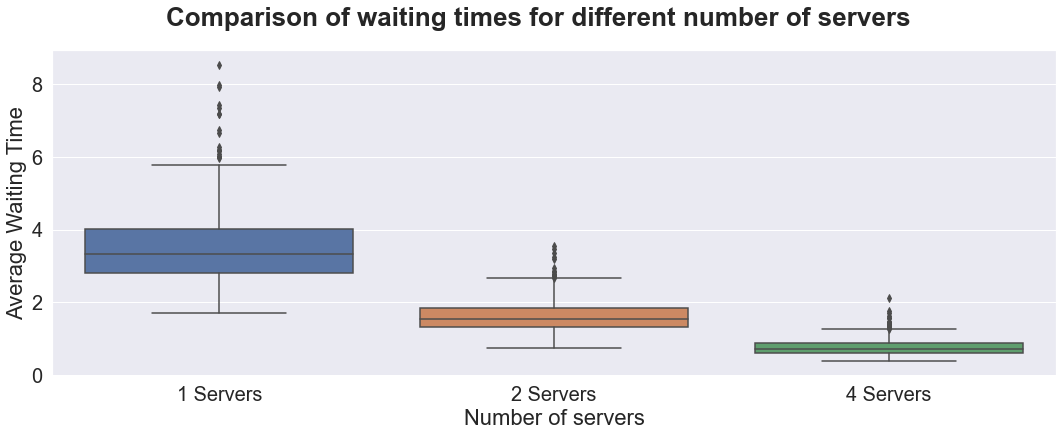

In [299]:
# Draw a boxplot
import seaborn as sns

sns.set(style='darkgrid')

fig, axis = plt.subplots(1, 1, figsize=(18, 6))
sns.boxplot(x='Servers', y='MeanWaitingTime', data=df)
axis.tick_params('both', labelsize=20)
axis.set_xlabel('Number of servers', fontsize=22)
axis.set_ylabel('Average Waiting Time', fontsize=22)
fig.suptitle('Comparison of waiting times for different number of servers', fontsize=26, fontweight='bold')

In [319]:
print("1, 2", ttest_ind(df.loc[df['Servers'] == '1 Servers']['MeanWaitingTime'], df.loc[df['Servers'] == '2 Servers']['MeanWaitingTime']))
print("1, 4", ttest_ind(df.loc[df['Servers'] == '1 Servers']['MeanWaitingTime'], df.loc[df['Servers'] == '4 Servers']['MeanWaitingTime']))
print("2, 4", ttest_ind(df.loc[df['Servers'] == '2 Servers']['MeanWaitingTime'], df.loc[df['Servers'] == '4 Servers']['MeanWaitingTime']))

1, 2 Ttest_indResult(statistic=37.19102144852346, pvalue=1.1680215834379428e-190)
1, 4 Ttest_indResult(statistic=59.9320722218898, pvalue=0.0)
2, 4 Ttest_indResult(statistic=37.94378358812566, pvalue=9.474995508392878e-196)
